# \[STBDA\] 04wk: tensorflow_경사하강법

김보람  
2023-06-19

> 해당 강의노트는 전북대학교 최규빈교수님
> [STBDA2022](https://guebin.github.io/STBDA2022/) 자료임

### imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-06-19 15:29:42.043174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [2]:
import tensorflow.experimental.numpy as tnp

In [3]:
tnp.experimental_enable_numpy_behavior()

### 미분

#### tf.GradientTape() 사용방법

`-` 예제9: 카페예제로 돌아오자.

In [4]:
x= tnp.array([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4])

In [5]:
tf.random.set_seed(43052)
epsilon=tf.random.normal([10])
y=10.2 + 2.2*x + epsilon

In [6]:
y

In [7]:
beta0 = tf.Variable(9.0)
beta1 = tf.Variable(2.0)

In [8]:
with tf.GradientTape(persistent=True) as tape:
    loss = sum((y-beta0-beta1*x)**2)

In [11]:
tape.gradient(loss,beta0)

In [10]:
tape.gradient(loss,beta1)

`-` 예제10: 카페예제의 매트릭스 버전

In [12]:
X= tnp.array([1]*10 +[20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4]).reshape(2,10).T
X

In [13]:
beta= tnp.array([9.0,2.0]).reshape(2,1)
beta

In [14]:
X@beta

In [15]:
beta_true= tnp.array([10.2,2.2]).reshape(2,1)
y= X@beta_true+epsilon.reshape(10,1)
y

In [16]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta)
    yhat= X@beta
    loss= (y-yhat).T @(y-yhat)

In [17]:
tape.gradient(loss,beta)

`-` 이론적인 값을 확인하면

loss = (y-Xb)’(y-Xb) = -2X’y + 2X’Xb

In [18]:
-2*X.T @ y + 2*X.T@X@beta

`-` 예제11: 위의 예제에서 이론적인 $\boldsymbol{\beta}$의 최적값을
찾아보고 (즉 $\boldsymbol{\hat\beta}$을 찾고) 그 지점에서 loss의
미분값(=접선의 기울기)를 구하라. 결과가 $\bf{0}$인지 확인하라. (단
${\bf 0}$은 길이가 2이고 각 원소가 0인 벡터)

$\beta$의 최적값은 $(X'X)^{-1}X'y$이다.

In [19]:
beta_optimal = tf.linalg.inv(X.T @ X) @ X.T  @y

In [20]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta_optimal)
    yhat= X@beta_optimal
    loss= (y-yhat).T @(y-yhat)

In [21]:
tape.gradient(loss,beta_optimal)

`-` beta_true에서의 기울기도 계산해보자.

In [22]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta_true)
    yhat= X@beta_true
    loss= (y-yhat).T @(y-yhat)

In [23]:
tape.gradient(loss,beta_true)

-   샘플사이즈가 커진다면 `tape.gradient(loss,beta_true)` $\approx$
    `tape.gradient(loss,beta_optimal)`
-   샘플사이즈가 커진다면 `beta_true` $\approx$ `beta_optimal`

## 경사하강법

### 최적화문제

`-` $loss=(\frac{1}{2}\beta-1)^2$를 최소하는 $\beta$를 컴퓨터를 활용하여
구하는 문제를 생각해보자. - 답은 $\beta=2$임을 알고 있다.

### 방법1: grid search

#### 알고리즘

1.  beta = \[-10.00,-9.99,…,10.00\] 와 같은 리스트를 만든다.

2.  (1)의 리스트의 각원소에 해당하는 loss를 구한다.

3.  (2)에서 구한 loss를 제일 작게 만드는 beta를 찾는다.

#### 구현코드

In [24]:
beta = np.linspace(-10,10,100)
loss = (beta/2 -1)**2

In [25]:
tnp.argmin([1,2,-3,3,4])

-   제일 작은 원소의 숫자?(번째)를 리턴해줌. -3이 제일 작으니까 0,1,“2”

In [26]:
tnp.argmin([1,2,3,-3,4])

In [27]:
tnp.argmin(loss)

In [28]:
beta[59]

In [29]:
beta[60]

In [30]:
(beta[59]/2-1)**2

In [31]:
(beta[60]/2-1)**2

#### 그리드서치의 문제점

`-` 비판1: \[-10,10\]이외에 해가 존재하면? - 이 예제의 경우는 운좋게
\[-10,10\]에서 해가 존재했음 - 하지만 임의의 고정된 $x,y$에 대하여
$loss(\beta)=(x\beta-y)^2$ 의 형태의 해가 항상 \[-10,10\]에서 존재한다는
보장은 없음 - 해결책: 더 넓게 많은 범위를 탐색하자?

`-` 비판2: 효율적이지 않음 - 알고리즘을 요약하면 결국 -10부터 10까지
작은 간격으로 조금씩 이동하며 loss를 조사하는 것이 grid search의
아이디어 - $\to$ 생각해보니까 $\beta=2$인 순간
$loss=(\frac{1}{2}\beta-1)^2=0$이 되어서 이것보다 작은 최소값은 존재하지
않는다(제곱은 항상 양수이어야 하므로) - $\to$ 따라서 $\beta=2$ 이후로는
탐색할 필요가 없다

### 방법2: gradient descent

#### 알고리즘!

1.  beta = -5 로 셋팅한다.

In [32]:
(-5/2-1)**2

1.  beta=-5 근처에서 조금씩 이동하여 loss를 조사해본다.

In [33]:
(-4.99/2-1)**2 ## 오른쪽으로 0.01 이동하고 loss조사

In [35]:
(-5.01/2-1)**2 ## 왼쪽으로 0.01 이동하고 loss조사

1.  (2)의 결과를 잘 해석하고 더 유리한 쪽으로 이동

2.  위의 과정을 반복하고 왼쪽, 오른쪽 어느쪽으로 움직여도 이득이 없다면
    멈춘다.

#### 알고리즘 분석

`-` (2)-(3)의 과정은
`beta=-5 에서 미분계수를 구하고 미분계수가 양수이면 왼쪽으로 움직이고 음수이면 오른쪽으로 움직인다`고
해석가능. 아래그림을 보면 더 잘 이해가 된다.

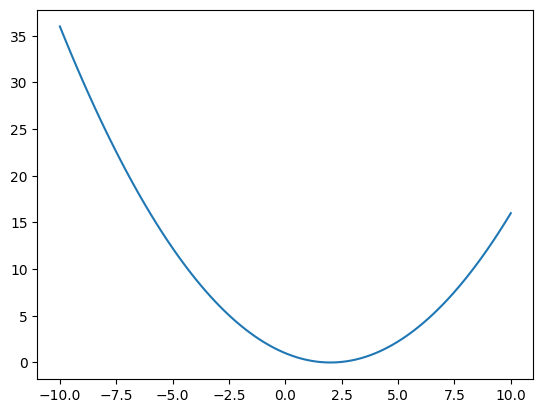

In [36]:
plt.plot(beta,loss)

#### 왼쪽/오른쪽중에 어디로 갈지 어떻게 판단하는 과정을 수식화?

`-` 아래와 같이 해석가능

-   오른쪽으로 0.01 간다 = beta_old에 0.01을 더함. (if, 미분계수가 음수)
-   왼쪽으로 0.01 간다. = beta_old에 0.01을 뺀다. (if, 미분계수가 양수)

`-` 그렇다면 \$\_{new} =

\$

#### 혹시 알고리즘을 좀 개선할수 있을까?

`-` 항상 0.01씩 움직여야 하는가?

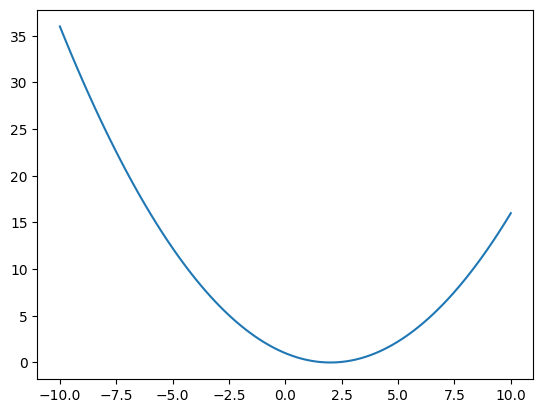

In [37]:
plt.plot(beta,loss)

`-` $\beta=-10$ 일 경우의 접선의 기울기? $\beta=-4$ 일때 접선의 기울기?

-   $\beta=-10$ =\> 기울기는 -6
-   $\beta=-4$ =\> 기울기는 -3

`-` 실제로 6,3씩 이동할순 없으니 적당한 $\alpha$ (예를들면
$\alpha=0.01$) 를 잡아서 곱한만큼 이동하자.

`-` 수식화하면

-   $\beta_{new} = \beta_{old} - \alpha~ loss'(\beta_{old})$
-   $\beta_{new} = \beta_{old} - \alpha~ \left[\frac{\partial}{\partial \beta }loss(\beta)\right]_{\beta=\beta_{old}}$

`-` $\alpha$의 의미 - $\alpha$가 크면 크게크게 움직이고 작으면 작게작게
움직인다. - $\alpha>0$ 이어야 한다.

#### 구현코드

`-` **iter 1**

$\beta=-10$이라고 하자.

In [41]:
beta = tf.Variable(-10.0)

In [44]:
with tf.GradientTape(persistent=True) as tape:
    loss = (beta/2-1)**2

In [45]:
tape.gradient(loss,beta)

$\beta = -10$ 에서 0.01만큼 움직이고 싶음

In [46]:
alpha= 0.01/6

In [47]:
alpha * tape.gradient(loss,beta)

In [48]:
beta.assign_sub(alpha * tape.gradient(loss,beta))

In [49]:
beta

`-` **iter2**

In [50]:
with tf.GradientTape(persistent=True) as tape:
    loss = (beta/2-1)**2

In [51]:
beta.assign_sub(tape.gradient(loss,beta)*alpha)

`-` for 문을 이용하자.

(강의용)

In [52]:
beta = tf.Variable(-10.0)

In [53]:
for k in range(10000):
    with tf.GradientTape(persistent=True) as tape:
        loss = (beta/2-1)**2
    beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [54]:
beta

(시도1)

In [55]:
beta = tf.Variable(-10.0)

In [56]:
for k in range(100):
    with tf.GradientTape(persistent=True) as tape:
        loss = (beta/2-1)**2
    beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [57]:
beta

(시도2)

In [58]:
beta = tf.Variable(-10.0)

In [59]:
for k in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        loss = (beta/2-1)**2
    beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [60]:
beta

`-` 너무 느린 것 같다? $\to$ $\alpha$를 키워보자!

#### 학습률

`-` 목표: $\alpha$에 따라서 수렴과정이 어떻게 달라지는 시각화해보자.

##### \[시각화 코드 예비학습\]

In [61]:
fig = plt.figure() # 도화지가 만들어지고 fig라는 이름을 붙인다.

In [62]:
ax = fig.add_subplot() # fig는 ax라는 물체를 만든다.

In [63]:
id(fig.axes[0])

In [64]:
id(ax)

In [65]:
pnts, = ax.plot([1,2,3],[4,5,6],'or')
pnts

-   pnts뒤에 ‘콤마’ 붙임-\> 튜플

In [66]:
pnts.get_xdata()

In [67]:
pnts.get_ydata()

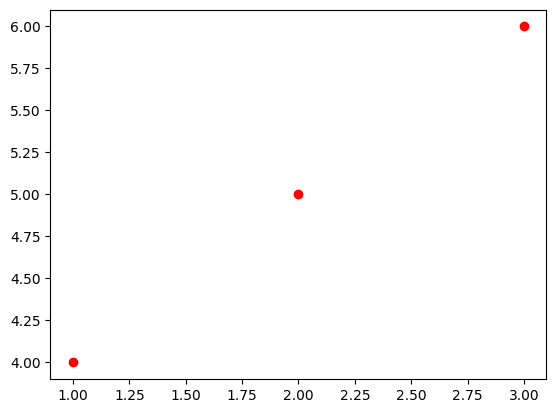

In [68]:
fig

In [69]:
pnts.set_ydata([5,5,5])

In [70]:
pnts.get_ydata()

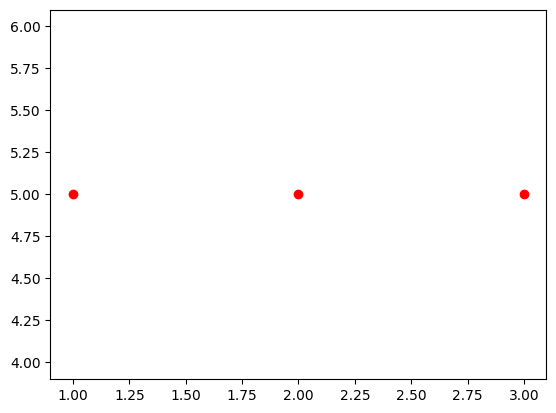

In [71]:
fig

`-` 응용

In [72]:
plt.rcParams["animation.html"]="jshtml"
from matplotlib import animation

In [73]:
def animate(i):
    if i%2 == 0:
        pnts.set_ydata([4,5,6])
    else:
        pnts.set_ydata([5,5,5])

In [74]:
ani = animation.FuncAnimation(fig,animate,frames=10)
ani

예비학습 끝

`-` beta_lst=\[-10,-9,-8\] 로 이동한다고 하자.

In [75]:
beta_lst = [-10,-9,-8]
loss_lst = [(-10/2-1)**2,(-9/2-1)**2,(-8/2-1)**2]

In [76]:
fig = plt.figure()

In [77]:
ax= fig.add_subplot()

In [78]:
_beta = np.linspace(-15,19,100)

In [79]:
ax.plot(_beta,(_beta/2-1)**2)

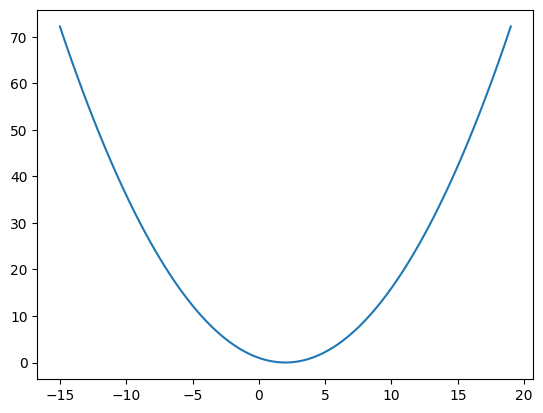

In [80]:
fig

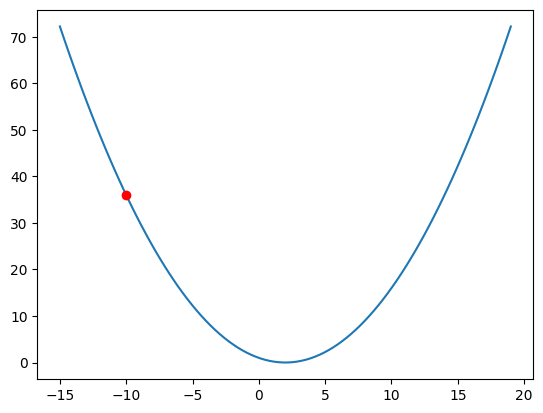

In [81]:
pnts, = ax.plot(beta_lst[0],loss_lst[0],'ro')
fig

In [82]:
def animate(i):
    pnts.set_xdata(beta_lst[:(i+1)])
    pnts.set_ydata(loss_lst[:(i+1)])

In [83]:
ani =animation.FuncAnimation(fig, animate, frames=3)
ani

`-` 최종아웃풋

In [84]:
beta = tf.Variable(-10.0)
alpha = 0.01/6

In [85]:
beta_lst=[]
loss_lst=[]

In [86]:
beta_lst.append(beta.numpy())
loss_lst.append((beta.numpy()/2-1)**2)

In [87]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(beta)
    loss = (beta/2-1)**2

In [88]:
beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [89]:
beta_lst.append(beta.numpy())
loss_lst.append((beta.numpy()/2-1)**2)

In [90]:
beta_lst, loss_lst

`-` for

In [91]:
beta = tf.Variable(-10.0)
alpha = 0.01/6
beta_lst=[]
loss_lst=[]
beta_lst.append(beta.numpy())
loss_lst.append((beta.numpy()/2-1)**2)
for k in range(100):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(beta)
        loss = (beta/2-1)**2
    beta.assign_sub(tape.gradient(loss,beta)*alpha)
    beta_lst.append(beta.numpy())
    loss_lst.append((beta.numpy()/2-1)**2)

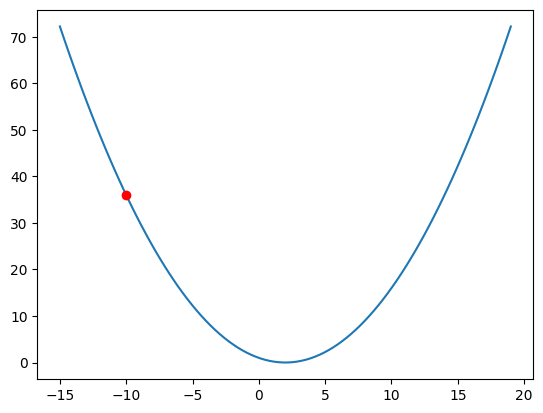

In [92]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(_beta,(_beta/2-1)**2)
pnts, = ax.plot(beta_lst[0],loss_lst[0],'or')

In [93]:
ani = animation.FuncAnimation(fig,animate,frames=100)
ani

### 숙제

$y=(x-1)^2$를 최소화 하는 $x$를 경사하강법을 이용하여 찾아라. 수렴과정을
animation으로 시각화하라. - x의 초기값은 -3으로 설정한다. - 적당한
$\alpha$를 골라서 100번의 반복안에 수렴하도록 하라.